# Coinflip Simulation

Consider a fair coin that always gives either heads or tails on each flip with equal probability. Assume (reasonably) that each flip is an independent event, meaning that the outcome of one flip does not influence the probability of any other flips. Flip this coin *N* times, and save the results. Then comb through the results and find "streaks" of *S* consecutive heads, and record the result of the flip immediately following the streak. **Question:** what's the probability of getting heads after *S* heads in a row? The purpose of this notebook is to demonstrate explicitly that the answer is 0.5.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
N = 100000
S = 8 # look for streaks of this many heads in a row
# Seed the random number gen for repeatability.
# Change the seed value for different random outcomes
np.random.seed(314159)

In [3]:
# Generate a length-N numpy array of random 1s and 0s.
# 1 represents heads, and 0 represents tails.
data = np.random.randint(low=0, high=2, size=N)

In [4]:
# Build a numpy array of the sub-array we're searching for.
streak = np.array([1]*S)

In [5]:
# Get a list of indexes of the first element of each streak
streak_starts = np.where(np.convolve(data, streak, mode='valid') == streak.sum())[0]
print 'Flipping a coin %d times \
resulted in %d streaks of %d \
heads in a row.' % (N, len(streak_starts), S)

Flipping a coin 100000 times resulted in 399 streaks of 8 heads in a row.


### FIXME

The above code **over-counts** the number of streaks, since it advances its streak-matching window through the data by one position, whether or not it just detected a streak. For example, if we're looking for streaks of 3 heads in a row in the data `1, 1, 1, 1, 1, 0, 0, 0`, the current algorithm would report 3 streaks of 3 heads each. Not sure at first glance if there's an elegant way to prevent this while still using a convolution one-liner...

## Aside: convolution 
The one-liner in the previous cell uses [convolution](https://en.wikipedia.org/wiki/Convolution) to extract the index of the first member of each streak of heads. It comes from this thread:
https://stackoverflow.com/questions/14890216/return-the-indexes-of-a-sub-array-in-an-array

The solutions that use `numpy`'s `as_strided()` look cool, but they're more esoteric
and `numpy`-specific. Check out the warnings in the docs:
https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.lib.stride_tricks.as_strided.html

**Note on `mode='valid'`:** this tells `convolve()` to return the convolution product only when
both signals overlap completely. The default `mode='full'` returns results from partial overlap, introducing edge effects that we need to reject. Concrete example: consider arrays A and B of lengths
100 and 7 respectively. Then `len(np.convolve(A, B, mode='full'))` is 106, whereas `len(np.convolve(A, B, mode='valid'))` is 94.

In our problem of counting streaks of 1s in an array, `mode='valid'` ensures that if
a streak occurs at the very start of the array, its index will be stored in `streak_starts` as 0.

Link to `numpy.convolve` docs:
https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.convolve.html
## End aside

In [6]:
# Save the outcome immediately following each streak.
# Careful about off-by-one errors here. For an
# example of a streak of length S=5:
# index:                i   i+1  i+2  i+3  i+4  i+5
# array:    ...,   0,   1,   1,   1,   1,   1,   0,   1, ...
# 
# The above diagram should convince you that if a streak
# starts at index i, then the element immediately following
# that streak in fact has index i + S, not i + S - 1 or something.
#
post_streak_outcomes = [data[i+S] for i in streak_starts]

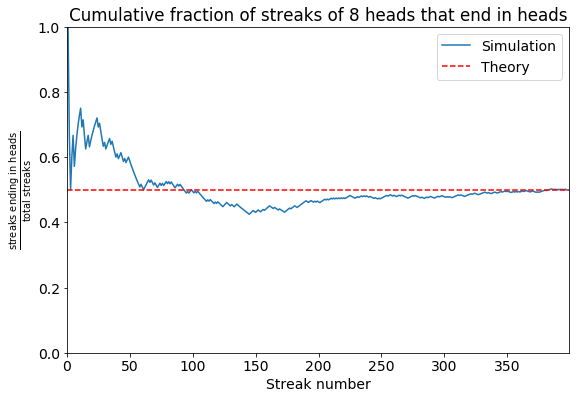

In [7]:
# Plot the cumulative fraction of post-streak outcomes that are heads.
# Theory predicts this to be 0.5.
import matplotlib as mpl
mpl.rcParams['font.size'] = 14
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
plt.plot(1.0 * np.cumsum(post_streak_outcomes) / 
         np.array(range(1, 1+len(post_streak_outcomes))))
ax.axhline(0.5, color='r', linestyle='--')
plt.ylim(0, 1)
plt.xlim(0, len(post_streak_outcomes))
plt.xlabel('Streak number')
plt.ylabel('$\\frac{\\mathrm{streaks\\ ending\\ in\\ heads}}{\\mathrm{total\\ streaks}}$')
plt.title('Cumulative fraction of streaks of %d heads that end in heads' % S);
plt.legend(['Simulation', 'Theory']);

In [8]:
# Finally, get the overall fraction of post-streak outcomes that were heads
1.0*sum(post_streak_outcomes)/len(post_streak_outcomes)

0.49874686716791977

## TODO/FIXME

Once I detect a streak and save the outcome of the flip immediately following that streak, should I *throw away* that streak and resume looking for subsequent streaks starting with the outcome? 

The way the code works now, I simply resume looking for streaks at the *second* element of the streak. Does this introduce bias? Long streaks of heads might artificially inflate the fraction of heads that terminate streaks of a fixed length. Then again, these long streaks of heads arise naturally from independent tosses of a fair coin, and in most cases, the above code seems to converge quite nicely on 0.5...

As an example, let's say I'm looking for streaks of length 3 in this data:
```
index:  0, 1, 2, 3, 4, 5, 6, 7, 8, 9
 data:  1, 1, 1, 1, 1, 1, 0, 0, 1, 1
```
The current algorithm finds the following streak indexes: 0, 1, 2, 3. The post-streak outcomes are: 1, 1, 1, 0.

If I "threw out" streaks after finding them, the only streak indexes I'd find are: 0, 3. The post-streak outcomes would then be: 1, 0.